In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(f"../input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
delta_sp = 0.25
delta_lp = 0.20
delta_sc = 0.25
delta_lc = 0.20

same_day = True
purchase_time = '09:45:00'

if same_day:
    dte_f = -1
else:
    dte_f = 0

In [2]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
       return pd.Series([0,0,0])
    return pd.Series([df1['strike'],df1['delta'],price])


def get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    total_lost = 0.0
    if underlying > strike_sc:
        total_lost = total_lost + (underlying - strike_sc)*100
        if underlying > strike_lc:
            total_lost = total_lost - (underlying - strike_lc)*100
    if underlying < strike_sp:
        total_lost = total_lost + (strike_sp - underlying)*100
        if underlying < strike_lp:
            total_lost = total_lost - (strike_lp - underlying)*100
    return total_lost

In [3]:
df_times = pd.DataFrame(df['quote_time'].unique())

df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected_sc'] = 0.0
df_trades['collected_lc'] = 0.0
df_trades['collected_sp'] = 0.0
df_trades['collected_lp'] = 0.0
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike_sp'] = 0
df_trades['strike_lp'] = 0
df_trades['strike_sc'] = 0
df_trades['strike_lc'] = 0
df_trades['delta_sp'] = 0.0
df_trades['delta_lp'] = 0.0
df_trades['delta_sc'] = 0.0
df_trades['delta_lc'] = 0.0
df_trades['net'] = 0.0

In [4]:
# Create new filtered dataframe with only calls above target delta
df_sc = df[(df['type']=="C") & (df['delta']>= delta_sc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
df_sc = df_sc.loc[df_sc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Only keep the min expiration date for each quote
df_sc = df_sc.loc[df_sc.groupby('quote_date')[['dte']].idxmin()['dte']]

df_lc = df[(df['type']=="C") & (df['delta']>= delta_lc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
df_lc = df_lc.loc[df_lc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Only keep the min expiration date for each quote
df_lc = df_lc.loc[df_lc.groupby('quote_date')[['dte']].idxmin()['dte']]

# Create new filtered dataframe with only puts above target delta
df_sp = df[(df['type']=="P") & (df['delta']>= delta_sp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
# We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
df_sp = df_sp.loc[df_sp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Now that we're certain we have the minimum expiration date, get the minimum delta
df_sp = df_sp.loc[df_sp.groupby('quote_date')[['dte']].idxmin()['dte']]

# Create new filtered dataframe with only puts above target delta
df_lp = df[(df['type']=="P") & (df['delta']>= delta_lp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
# We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
df_lp = df_lp.loc[df_lp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Now that we're certain we have the minimum expiration date, get the minimum delta
df_lp = df_lp.loc[df_lp.groupby('quote_date')[['dte']].idxmin()['dte']]


In [5]:
#Need to figure out how to extract strike, delta, and the average between bid/ask from one "apply" operation
df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sc), axis = 1).T.values
df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lc), axis = 1).T.values
df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sp), axis = 1).T.values
df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lp), axis = 1).T.values
df_trades['collected'] = df_trades['collected_sc'] + -1*df_trades['collected_lc'] + df_trades['collected_sp'] + -1*df_trades['collected_lp'] 
df_trades['lost'] = df_trades.apply(lambda row : get_amount_lost(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], row['strike_lc']), axis=1)
df_trades['net'] = df_trades['collected'] - df_trades['lost']
                                                                                         
# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [6]:
df_trades.head()

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,strike_sc,strike_lc,delta_sp,delta_lp,delta_sc,delta_lc,net
0,2022-01-03,2022-01-03,450.0,305.0,385.0,295.0,235.0,0.0,4775.0,4770.0,4800.0,4805.0,0.2642,0.2094,0.3220,0.2423,235.0
1,2022-01-05,2022-01-05,440.0,302.5,450.0,350.0,237.5,500.0,4770.0,4765.0,4800.0,4805.0,0.2709,0.2192,0.2893,0.2203,-262.5
2,2022-01-07,2022-01-07,470.0,345.0,520.0,420.0,225.0,349.0,4680.0,4675.0,4720.0,4725.0,0.2551,0.2137,0.2684,0.2130,-124.0
3,2022-01-10,2022-01-10,560.0,430.0,710.0,500.0,340.0,500.0,4600.0,4590.0,4650.0,4655.0,0.2732,0.2053,0.2532,0.2089,-160.0
4,2022-01-12,2022-01-12,555.0,425.0,575.0,490.0,215.0,0.0,4705.0,4700.0,4750.0,4755.0,0.2507,0.2171,0.2767,0.2269,215.0


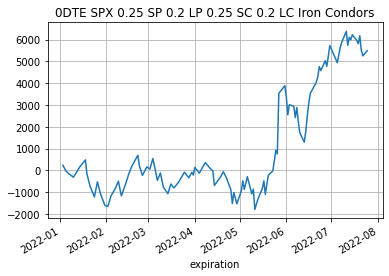

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
df_trade_plot.plot(ax=ax)
plt.title(f"0DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC Iron Condors")
plt.grid()
plt.savefig(f"0DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")